# Summary

- We can use pre-trained models for general image classification
- Convolutional layers let us turn an image into a vector
- Dense layers use the vector to make the predictions
- Instead of training a model from scratch, we can use transfer learning and re-use already trained convolutional layers
- First, train a small model (150x150) before training a big one (299x299)
- Learning rate - how fast the model trians. Fast learners aren't always best ones
- We can save the best model using callbacks and checkpointing
- To avoid overfitting, use dropout and augmentation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [2]:
print("GPU disponível:", tf.config.list_physical_devices('GPU'))

GPU disponível: []


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU configurada para uso.")
    except RuntimeError as e:
        print(e)

# 8.1 Fashion Classification
- using images as data source instead of tabular data
- classifying images of t-shirts using a convolutional neural network
- 5000 images and 20 different classes https://www.kaggle.com/agrigorev/clothing-dataset-full
- see corresponding medium.com article https://medium.com/data-science-insider/clothing-dataset-5b72cd7c3f1f
- deep learning with tensorflow and keras
- parameters, layers, regularization
- smaller version of the dataset: https://github.com/alexeygrigorev/clothing-dataset-small/tree/master

In [4]:
path = './clothing-dataset-small/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = f'{path}/{name}'

# 8.2 TensorFlow and Keras

- import tensorflow as tf: to import tensorflow library
- from tensorflow import keras: to import keras
- from tensorflow.keras.preprocessing.image import load_img: to import load_img function
- load_img('path/to/image', targe_size=(150,150)): to load the image of 150 x 150 size in PIL format
- np.array(img): convert image into a numpy array of 3D shape, where each row of the array represents the value of red, green, and blue color channels of one pixel in the image.

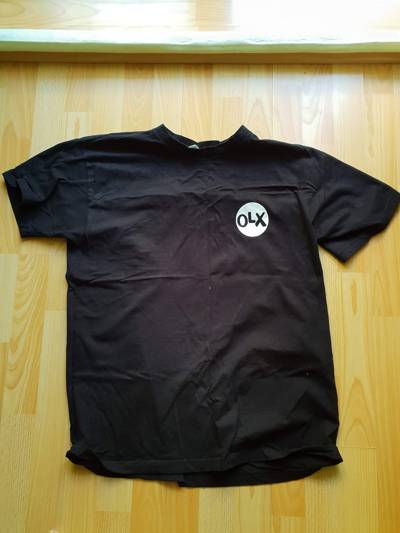

In [5]:
load_img(fullname)

In [6]:
# redimensiona a img em 299x299 pixels pois modelos pré-treinados exigem entradas fixas
img = load_img(fullname, target_size=(299, 299))

In [7]:
x = np.array(img)
x.shape

(299, 299, 3)

# 8.3 Pre-trained Convolutional Neural Networks
- Imagenet dataset: https://www.image-net.org/
- Pre-trained models: https://keras.io/api/applications/


- The keras applications has different pre-trained models with different architectures. We'll use the model Xception which takes the input image size of (229, 229) and each image pixels is scaled between -1 and 1
- We create the instance of the pre-trained model using `model = Xception(weights='imagenet', input_shape=(299, 229, 3))`. Our model will use the weights from pre-trained imagenet and expecting the input shape (229, 229, 3) of the image
- Along with image size, the model also expects the batch_size which is the size of the batches of data (default 32). If one image is passed to the model, then the expected shape of the model should be (1, 229, 229, 3)
- The image data was preprocessed using preprocess_input function, therefore, we'll have to use this function on our data to make predictions, like so: `X = preprocess_input(X)`
- The `pred = model.predict(X)` function returns 2D array of shape (1, 1000), where 1000 is the probablity of the image classes. decode_predictions(pred) can be used to get the class names and their probabilities in readable format.
- In order to make the pre-trained model useful specific to our case, we'll have to do some tweak, which we'll do in the coming sections.
    - `from tensorflow.keras.applications.xception import Xception`: import the model from keras applications
    - `from tensorflow.keras.application.xception import preprocess_input`: function to perform preprocessing on images
    - `from tensorflow.keras.applications.xception import decode_predictions`: extract the predctions class name in the form of tuple of list
    - `model.predict(X)`: function make predictions on the test images

In [8]:
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

In [9]:
X = np.array([x])

In [10]:
X.shape

(1, 299, 299, 3)

In [11]:
X = preprocess_input(X)

In [12]:
pred = model.predict(X)

1/1 [==============================] - 1s 1s/step


In [13]:
decode_predictions(pred)

[[('n03595614', 'jersey', 0.67924464),
  ('n02916936', 'bulletproof_vest', 0.039600383),
  ('n04370456', 'sweatshirt', 0.03529961),
  ('n03710637', 'maillot', 0.01088413),
  ('n04525038', 'velvet', 0.0018057609)]]

# 8.5 Transfer Learning
- Reading data with ImageDataGenerator
- Train Xception on smaller images (150x150)

In [14]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [15]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(150, 150),
    batch_size=32
)

Found 3068 images belonging to 10 classes.


In [16]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [17]:
X, y = next(train_ds)

In [18]:
y[:5]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [21]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 341 images belonging to 10 classes.


In [22]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

base_model.trainable = False



inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vectors)

model = keras.Model(inputs, outputs)

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of b0042744bf5b25fce3cb969f33bebb97 so we will re-download the data.
83683744/83683744 [==============================] - 44s 1us/step


In [23]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [24]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 60s 582ms/step - loss: 1.2211 - accuracy: 0.6783 - val_loss: 0.9768 - val_accuracy: 0.7390
Epoch 2/10
96/96 [==============================] - 49s 504ms/step - loss: 0.5975 - accuracy: 0.8145 - val_loss: 0.8477 - val_accuracy: 0.7742
Epoch 3/10
96/96 [==============================] - 47s 492ms/step - loss: 0.4330 - accuracy: 0.8651 - val_loss: 0.7971 - val_accuracy: 0.7977
Epoch 4/10
96/96 [==============================] - 48s 500ms/step - loss: 0.2557 - accuracy: 0.9126 - val_loss: 0.8734 - val_accuracy: 0.8065
Epoch 5/10
96/96 [==============================] - 48s 502ms/step - loss: 0.1791 - accuracy: 0.9364 - val_loss: 0.8481 - val_accuracy: 0.8123
Epoch 6/10
96/96 [==============================] - 52s 542ms/step - loss: 0.0894 - accuracy: 0.9716 - val_loss: 0.8654 - val_accuracy: 0.8006
Epoch 7/10
96/96 [==============================] - 54s 558ms/step - loss: 0.0944 - accuracy: 0.9677 - val_loss: 0.8648 - val_accuracy: 0.8211

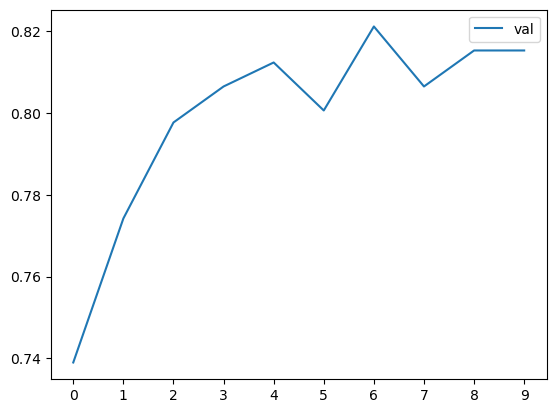

In [25]:
#plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

# 8.6 Adjusting the learning rate
- What's the learning rate
- Trying different values

In [26]:
def make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vectors)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [27]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/10
96/96 [==============================] - 69s 688ms/step - loss: 1.9322 - accuracy: 0.3478 - val_loss: 1.6044 - val_accuracy: 0.5044
Epoch 2/10
96/96 [==============================] - 51s 535ms/step - loss: 1.3841 - accuracy: 0.5694 - val_loss: 1.2619 - val_accuracy: 0.6158
Epoch 3/10
96/96 [==============================] - 53s 551ms/step - loss: 1.1417 - accuracy: 0.6441 - val_loss: 1.0839 - val_accuracy: 0.6686
Epoch 4/10
96/96 [==============================] - 49s 514ms/step - loss: 0.9997 - accuracy: 0.6871 - val_loss: 0.9717 - val_accuracy: 0.7243
Epoch 5/10
96/96 [==============================] - 53s 552ms/step - loss: 0.9092 - accuracy: 0.7151 - val_loss: 0.8944 - val_accuracy: 0.7507
Epoch 6/10
96/96 [==============================] - 52s 543ms/step - loss: 0.8386 - accuracy: 0.7357 - val_loss: 0.8432 - val_accuracy: 0.7595
Epoch 7/10
96/96 [==============================] - 52s 537ms/step - loss: 0.7852 - accuracy: 0.7503 - val_loss: 0.8048 - val_accuracy:

In [28]:
del scores[0.1]
del scores[0.0001]

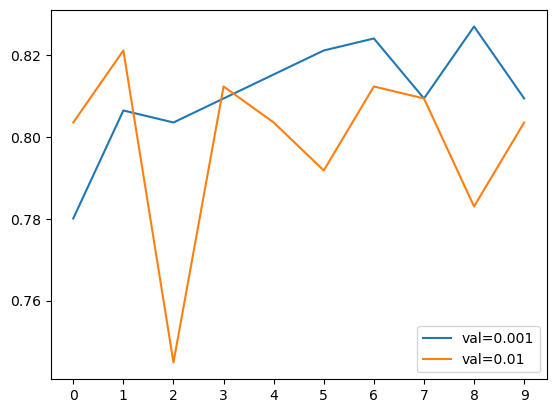

In [29]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [30]:
learning_rate = 0.001

# 8.7 Checkpointing
- Saving the best model only
- Training a model with callbacks

In [31]:
model.save_weights('model_v1.h5', save_format='h5')

In [32]:
chechpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [33]:
learning_rate = 0.001

model = make_model(learning_rate=learning_rate)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[chechpoint]
)

Epoch 1/10
96/96 [==============================] - 57s 552ms/step - loss: 1.1150 - accuracy: 0.6255 - val_loss: 0.7206 - val_accuracy: 0.7742
Epoch 2/10
96/96 [==============================] - 55s 571ms/step - loss: 0.6347 - accuracy: 0.7842 - val_loss: 0.6095 - val_accuracy: 0.8035
Epoch 3/10
96/96 [==============================] - 55s 577ms/step - loss: 0.5098 - accuracy: 0.8341 - val_loss: 0.5793 - val_accuracy: 0.8065
Epoch 4/10
96/96 [==============================] - 53s 549ms/step - loss: 0.4362 - accuracy: 0.8585 - val_loss: 0.5518 - val_accuracy: 0.8211
Epoch 5/10
96/96 [==============================] - 59s 611ms/step - loss: 0.3748 - accuracy: 0.8872 - val_loss: 0.5416 - val_accuracy: 0.8182
Epoch 6/10
96/96 [==============================] - 55s 566ms/step - loss: 0.3321 - accuracy: 0.9025 - val_loss: 0.5671 - val_accuracy: 0.8006
Epoch 7/10
96/96 [==============================] - 56s 585ms/step - loss: 0.2910 - accuracy: 0.9201 - val_loss: 0.5319 - val_accuracy: 0.8240

# 8.8 Adding more layers
- Adding one inner dense layer
- Experimenting with different sizes of inner layer

In [34]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    
    outputs = keras.layers.Dense(10)(inner)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [35]:
learning_rate = 0.001

scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()

10
Epoch 1/10
96/96 [==============================] - 61s 594ms/step - loss: 1.4885 - accuracy: 0.4922 - val_loss: 0.9944 - val_accuracy: 0.6921
Epoch 2/10
96/96 [==============================] - 55s 578ms/step - loss: 0.8873 - accuracy: 0.7141 - val_loss: 0.7652 - val_accuracy: 0.7390
Epoch 3/10
96/96 [==============================] - 56s 587ms/step - loss: 0.7119 - accuracy: 0.7643 - val_loss: 0.7070 - val_accuracy: 0.7537
Epoch 4/10
96/96 [==============================] - 56s 583ms/step - loss: 0.6062 - accuracy: 0.7982 - val_loss: 0.6572 - val_accuracy: 0.7742
Epoch 5/10
96/96 [==============================] - 55s 575ms/step - loss: 0.5262 - accuracy: 0.8250 - val_loss: 0.6162 - val_accuracy: 0.7889
Epoch 6/10
96/96 [==============================] - 57s 591ms/step - loss: 0.4685 - accuracy: 0.8501 - val_loss: 0.6048 - val_accuracy: 0.7771
Epoch 7/10
96/96 [==============================] - 57s 592ms/step - loss: 0.4131 - accuracy: 0.8716 - val_loss: 0.6034 - val_accuracy: 0.7

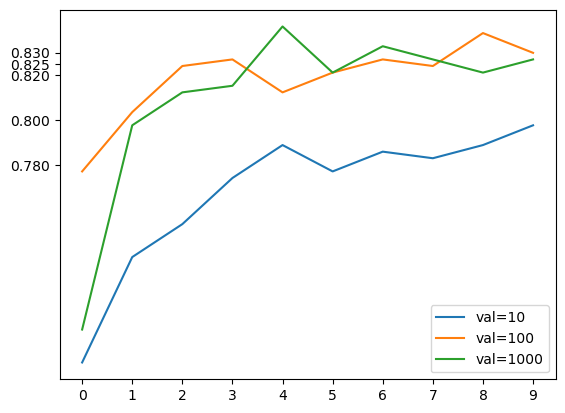

In [37]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
plt.yticks([0.78, 0.80, 0.82, 0.825, 0.83])
plt.legend()

# 8.9 Regularization and dropout
- Regularizing by freezing a part of the network
- Adding dropout to our model
- Experimenting with different values

In [38]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(10)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [39]:
learning_rate = 0.001
size = 100

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    scores[droprate] = history.history

    print()
    print()

0.0
Epoch 1/30
96/96 [==============================] - 55s 532ms/step - loss: 0.9534 - accuracy: 0.6659 - val_loss: 0.6231 - val_accuracy: 0.7625
Epoch 2/30
96/96 [==============================] - 51s 525ms/step - loss: 0.5049 - accuracy: 0.8207 - val_loss: 0.5434 - val_accuracy: 0.8123
Epoch 3/30
96/96 [==============================] - 50s 517ms/step - loss: 0.3589 - accuracy: 0.8758 - val_loss: 0.5702 - val_accuracy: 0.8182
Epoch 4/30
96/96 [==============================] - 50s 523ms/step - loss: 0.2550 - accuracy: 0.9185 - val_loss: 0.5715 - val_accuracy: 0.8006
Epoch 5/30
96/96 [==============================] - 50s 522ms/step - loss: 0.1940 - accuracy: 0.9443 - val_loss: 0.6045 - val_accuracy: 0.8065
Epoch 6/30
96/96 [==============================] - 50s 518ms/step - loss: 0.1356 - accuracy: 0.9668 - val_loss: 0.5571 - val_accuracy: 0.8475
Epoch 7/30
96/96 [==============================] - 50s 524ms/step - loss: 0.0944 - accuracy: 0.9837 - val_loss: 0.5974 - val_accuracy: 0.

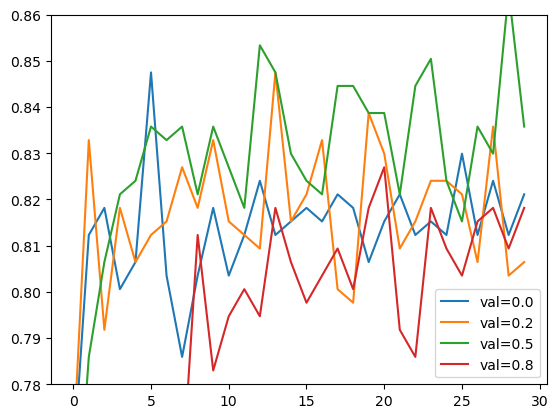

In [40]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.ylim(0.78, 0.86)
plt.legend()

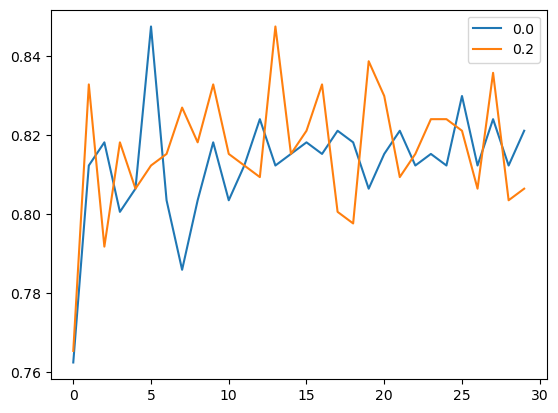

In [41]:
hist = scores[0.0]
plt.plot(hist['val_accuracy'], label=0.0)

hist = scores[0.2]
plt.plot(hist['val_accuracy'], label=0.2)

plt.legend()
#plt.plot(hist['accuracy'], label=('val=%s' % droprate))

# 8.10 Data augmentation
- Different data augmentations
- Training a model with augmentations
- How to select data augmentations?

In [42]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
#     vertical_flip=True,
)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(150, 150),
    batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [43]:
learning_rate = 0.001
size = 100
droprate = 0.2

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
96/96 [==============================] - 56s 550ms/step - loss: 1.0686 - accuracy: 0.6307 - val_loss: 0.6551 - val_accuracy: 0.7889
Epoch 2/50
96/96 [==============================] - 52s 540ms/step - loss: 0.6319 - accuracy: 0.7767 - val_loss: 0.6487 - val_accuracy: 0.7830
Epoch 3/50
96/96 [==============================] - 54s 558ms/step - loss: 0.4742 - accuracy: 0.8416 - val_loss: 0.5780 - val_accuracy: 0.7977
Epoch 4/50
96/96 [==============================] - 53s 545ms/step - loss: 0.3603 - accuracy: 0.8745 - val_loss: 0.5410 - val_accuracy: 0.8475
Epoch 5/50
96/96 [==============================] - 53s 557ms/step - loss: 0.2762 - accuracy: 0.9123 - val_loss: 0.5489 - val_accuracy: 0.8065
Epoch 6/50
96/96 [==============================] - 54s 563ms/step - loss: 0.2156 - accuracy: 0.9338 - val_loss: 0.5609 - val_accuracy: 0.8182
Epoch 7/50
96/96 [==============================] - 55s 573ms/step - loss: 0.1755 - accuracy: 0.9475 - val_loss: 0.5696 - val_accuracy: 0.8152

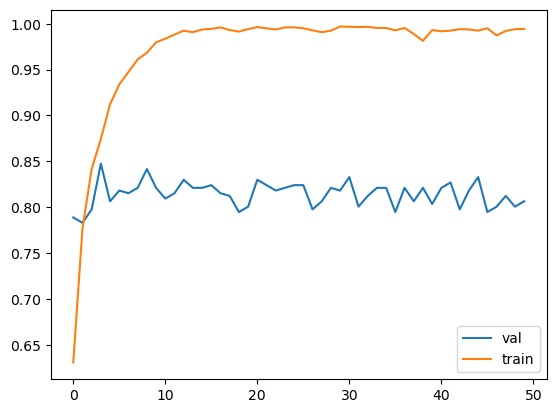

In [44]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

# 8.11 Training a larger model
- Train a 299x299 model

In [45]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100,
               droprate=0.5):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(10)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [46]:
input_size = 299

In [47]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(input_size, input_size),
    batch_size=32
)


val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [48]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [49]:
learning_rate = 0.0005
size = 100
droprate = 0.2

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds,
                   callbacks=[checkpoint])

Epoch 1/50
96/96 [==============================] - 206s 2s/step - loss: 0.9968 - accuracy: 0.6809 - val_loss: 0.5576 - val_accuracy: 0.8240
Epoch 2/50
96/96 [==============================] - 197s 2s/step - loss: 0.5184 - accuracy: 0.8305 - val_loss: 0.4324 - val_accuracy: 0.8534
Epoch 3/50
96/96 [==============================] - 198s 2s/step - loss: 0.4329 - accuracy: 0.8546 - val_loss: 0.4034 - val_accuracy: 0.8710
Epoch 4/50
96/96 [==============================] - 199s 2s/step - loss: 0.3831 - accuracy: 0.8732 - val_loss: 0.3909 - val_accuracy: 0.8592
Epoch 5/50
96/96 [==============================] - 197s 2s/step - loss: 0.3523 - accuracy: 0.8794 - val_loss: 0.3803 - val_accuracy: 0.8592
Epoch 6/50
96/96 [==============================] - 197s 2s/step - loss: 0.3126 - accuracy: 0.8944 - val_loss: 0.3959 - val_accuracy: 0.8622
Epoch 7/50
96/96 [==============================] - 201s 2s/step - loss: 0.2915 - accuracy: 0.8937 - val_loss: 0.4044 - val_accuracy: 0.8622
Epoch 8/50
96

# 8.12 Using the model
- Loading the model
- Evaluating the model
- Getting predictions

In [50]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    './clothing-dataset-small/test',
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

Found 372 images belonging to 10 classes.


In [51]:
model = keras.models.load_model('xception_v4_1_38_0.894.h5')

In [52]:
model.evaluate(test_ds)

12/12 [==============================] - 24s 2s/step - loss: 0.2624 - accuracy: 0.9113


[0.26238688826560974, 0.9112903475761414]

In [53]:
path = 'clothing-dataset-small/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'

In [54]:
img = load_img(path, target_size=(299, 299))

In [55]:
x = np.array(img)
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [56]:
X = preprocess_input(X)

In [57]:
pred = model.predict(X)

1/1 [==============================] - 1s 1s/step


In [58]:
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

In [59]:
dict(zip(classes, pred[0]))

{'dress': -4.0876417,
 'hat': -3.8721738,
 'longsleeve': -4.220812,
 'outwear': -3.5885434,
 'pants': 11.840306,
 'shirt': -3.8742576,
 'shoes': -5.473212,
 'shorts': 3.359907,
 'skirt': -5.941244,
 't-shirt': -3.074874}